In [592]:
# Matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
import sklearn
import tensorflow as tf
from zigzag import *
import pandas as pd
import numpy as np
import pickle
# Numpy and Pandas
# Ohter import
import time
import sys

In [544]:
assert hasattr(tf, "function") # Be sure to use tensorflow 2.0

In [545]:
def indicator_mod(az):
    indic = az
    maxx = -9999
    minn = 9999
    for i in range(len(indic)):
        x = indic[i]
        for val in x:
            if val != x[-1]:
                if val > maxx:
                    maxx = val
                if val < minn:
                    minn = val
        for xi in range(len(x) - 1):
            indic[i][xi] = (indic[i][xi] - minn) / (maxx - minn)
            # indic[i] = (indic[i] - minn) / (maxx - minn)
    return indic

def indicator_mod_simple(az):
    x = az
    maxx = -9999
    minn = 9999
    for val in x:
        if val > maxx:
            maxx = val
        if val < minn:
            minn = val
    
    for xi in range(len(x)):
        if (x[xi] - minn) / (maxx - minn+0.0001)>1:
            x[xi] = 1
        else:
            x[xi] = (x[xi] - minn) / (maxx - minn+0.00000001)
            # indic[i] = (indic[i] - minn) / (maxx - minn)
    return x


In [676]:
def prepa_data(lst_open, lst_high, lst_low, lst_close):
    lst_x_input = []
    for i in range(23, len(lst_open)):
        #lst_temp1 = []
        #for i2 in range(24):
        #    lst_temp1.append(lst_open[i - i2])
        #for i2 in range(6):
        #    lst_temp.append(lst_high[i - i2])
        #for i2 in range(6):
        #    lst_temp.append(lst_low[i - i2])
        lst_temp2=[]
        for i2 in range(24):
            lst_temp2.append(lst_close[i - i2])
        lst_x_input.append(lst_temp2)
    return lst_x_input

In [659]:
def get_basic_model():
    model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

In [641]:
def plot_pivots(X, pivots):
    plt.plot(np.arange(len(X)), X, 'k:', alpha=0.5)
    plt.plot(np.arange(len(X))[pivots != 0], X[pivots != 0], 'k-')
    plt.scatter(np.arange(len(X))[pivots == -1], X[pivots == -1], color='g')
    plt.scatter(np.arange(len(X))[pivots == 1], X[pivots == 1], color='r')


In [642]:
in_long_trade = False
buy_part = 100
ref_price = 0
precision = 10
reserve = 1000
position = 0
nb_bon_trade = 0
nb_total_trade = 0
def buy_sell_trade(actu_choice, actu_choice_2, close_price):
    global in_long_trade, buy_part, ref_price, precision, reserve, position, nb_bon_trade, nb_total_trade
    choice_final = 0
    if actu_choice > 0.5:
        # pas de short nous on utilise spot
        if not in_long_trade:
                if reserve > buy_part:
                    # print('start long')
                    ref_price = close_price
                    reserve -= buy_part
                    reserve -= (buy_part * 0.0750 / 100) * 1
                    position = round(buy_part / ref_price, precision)
                    in_long_trade = True
                    choice_final = -1
                    # print('open ', close_price, lst_price_open[i], lst_price_x_open[i])
                    # print('close', lst_price_x_close[i], lst_price_close[i])
    elif actu_choice_2 > 0.5:
        if in_long_trade:
            # print('stop long')
            reserve += position * close_price
            reserve -= (position * close_price * 0.0750 / 100) * 1
            in_long_trade = False
            if (position * close_price) - buy_part > 0:
                nb_bon_trade += 1
            nb_total_trade += 1
            choice_final = 1
            # print('open ', close_price, lst_price_open[i], lst_price_x_open[i])
            # print('close', lst_price_x_close[i], lst_price_close[i])

    return choice_final


In [643]:
with open("data_train.data", "rb") as fic:
    candlesticks = pickle.load(fic)

with open("data_test.data", "rb") as fic:
    candlesticks2 = pickle.load(fic)

In [675]:
## data = candlesticks
data = candlesticks
df = pd.DataFrame(data=data,
                  columns=["open_time", "open", "high", "low", "close", "volume", "close_time",
                           "quote_asset_volume",
                           "nb_volume", "taker_buy_base_asset_volume", "taker_buy_quote_asset_asset_volume",
                           "ignored"],
                  dtype=float)
df = df.copy()

# uniformiser les données
lst_price_open = df.open.values[27:]
lst_price_high = df.high.values[27:]
lst_price_low = df.low.values[27:]
lst_price_close = df.close.values[27:]

lst_x_input = prepa_data(lst_price_open, lst_price_high, lst_price_low, lst_price_close)

pivots = peak_valley_pivots(lst_price_close, 0.03, -0.03)

#lst_x_input = indicator_mod(lst_x_input)
lst_price_open = lst_price_open[23:]
lst_price_high = lst_price_high[23:]
lst_price_low = lst_price_low[23:]
lst_price_close = lst_price_close[23:]
pivots = pivots[23:]

print('set x input')


for i in range(len(lst_x_input)):
    one = lst_x_input[i][0:24]
    #two = lst_x_input[i][24:48]
    #tree = lst_x_input[i][12:18]
    #f = lst_x_input[i][18:24]
    #
    #one = preprocessing.normalize(one)
    #two = preprocessing.normalize(two)
    #tree = preprocessing.normalize(tree)
    #f = preprocessing.normalize(f)
    lst_x_input[i] = [one, two]
lst_x_input = np.array(lst_x_input, dtype=object)
lst_x_input = tf.convert_to_tensor(lst_x_input)

#plot_pivots(lst_price_close, pivots)
print('set data')
train_data = []
targets_data = []
for i in range(len(pivots)):
    if pivots[i] == -1:
        train_data.append(lst_x_input[i])
        targets_data.append(0.01)
        #pivots[i] = -1
    elif pivots[i] == 1:
        train_data.append(lst_x_input[i])
        targets_data.append(1.99)
        #pivots[i] = 1
train_data = np.array(train_data)
targets_data = np.array(targets_data)
print('good data')

set x input


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.float64).

In [645]:
[10,50,70, 100, 20] + [80, 20, 10]
list(sklearn.preprocessing.minmax_scale([[8.00, 8.510, 8.00]], feature_range=(0, 1), axis=0, copy=True))[0]
#preprocessing.normalize([[8.00, 8.510, 8.00]])
#indicator_mod(lst_price_open[:10])

array([0., 0., 0.])

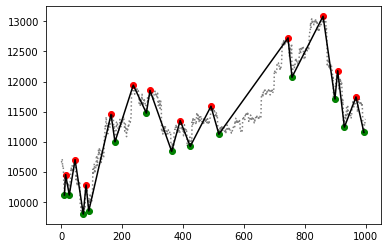

In [646]:
plot_pivots(lst_price_close[:1000], pivots[:1000])

In [657]:
lst_x_input[0]

array([[10748.3, 10980.33, 11020.87, 10972.45, 10964.0, 10943.18,
        10994.45, 10989.02, 11004.67, 11067.17, 11107.17, 11125.31,
        11090.63, 11115.29, 11178.13, 11086.1, 10998.0, 11013.47,
        10983.7, 10923.9, 10945.96, 11043.09, 10960.4, 11012.18],
       [10664.0, 10750.0, 10979.62, 11022.65, 10970.28, 10960.63,
        10943.13, 10994.45, 10989.85, 11005.12, 11067.18, 11106.79,
        11127.03, 11091.0, 11112.46, 11178.08, 11083.12, 10997.8,
        11015.08, 10983.7, 10923.89, 10945.52, 11039.61, 10962.89]],
      dtype=object)

In [658]:
#normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)

In [660]:
history = model.fit(train_data, targets_data, epochs=100, batch_size=1)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.float64).

In [ ]:
#history = model.fit(train_data, targets_data, epochs=10, validation_split=0.2)


In [ ]:
loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_accuracy"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()



In [ ]:
loss, acc = model.evaluate(train_data, targets_data)
print("Test Loss", loss)
print("Test Accuracy", acc)

In [ ]:
#n = np.array([[1, 2, 3, 4]])

#np.argmax(n[0])